# Hybrid AI Approach to Customer Segmentation and Sales Prediction

## Import Modules

In [122]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder  
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import VotingRegressor


# Data Preprocessing

## Load the Dataset

In [123]:
df = pd.read_csv('pseudo_customer_data.csv')

### Handling NA Values

In [124]:
dataset = df

no_nas = True
for col in dataset.columns:
    if dataset[col].isnull().any():
        print(f"There are nulls in: {col}")
        no_nas = False

if no_nas:
    print("Yup, all good no NAs in any column")

Yup, all good no NAs in any column


### Encoding

In [125]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

In [126]:
df.drop(columns='CustomerID', inplace=True)

In [127]:
df.head()

,Age,Gender,Annual Income (k$),Spending Score (1-100),Purchase History,Sales
0,41,0,147,79,35,245
1,42,1,37,32,31,403
2,24,0,72,8,41,492
3,69,1,60,97,70,350
4,23,0,36,18,58,348


### Scaling

In [128]:
use_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
use_cols

['Age',
 'Gender',
 'Annual Income (k$)',
 'Spending Score (1-100)',
 'Purchase History',
 'Sales']

In [129]:
# Scaling numerical features
scaler = StandardScaler()
df[use_cols] = scaler.fit_transform(df[use_cols])


In [130]:
df.head()

,Age,Gender,Annual Income (k$),Spending Score (1-100),Purchase History,Sales
0,-0.174688,-0.988862,1.693494,1.013533,-0.615309,-0.805816
1,-0.107573,1.011263,-1.152045,-0.617459,-0.761304,-0.285637
2,-1.315653,-0.988862,-0.246646,-1.450306,-0.396317,0.007375
3,1.704548,1.011263,-0.557069,1.638168,0.662144,-0.460128
4,-1.382769,-0.988862,-1.177914,-1.103286,0.224160,-0.466712


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     5000 non-null   float64
 1   Gender                  5000 non-null   float64
 2   Annual Income (k$)      5000 non-null   float64
 3   Spending Score (1-100)  5000 non-null   float64
 4   Purchase History        5000 non-null   float64
 5   Sales                   5000 non-null   float64
dtypes: float64(6)
memory usage: 234.5 KB


# Customer Segmentation

#### Determining optimal number of clusters

In [132]:
wcss = []
range_clusters = range(1, 15)  # Adjust the range of clusters as needed
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df)  
    wcss.append(kmeans.inertia_)

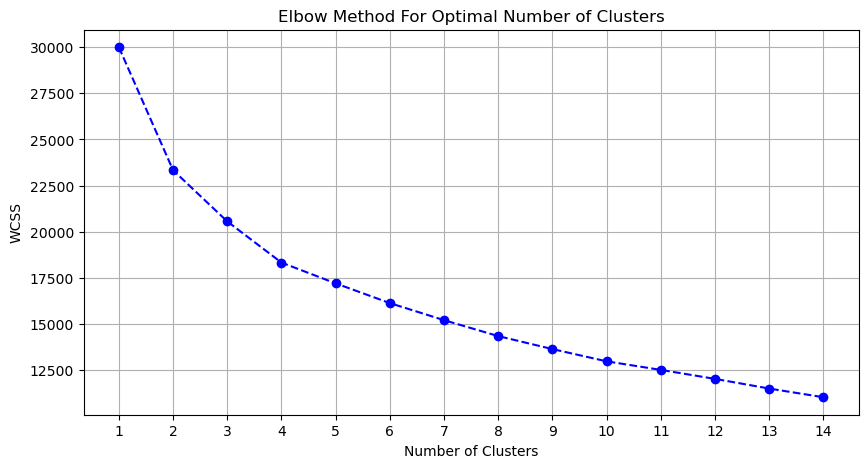

In [133]:
# Plot the WCSS values
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

#### Training K-means

In [134]:
clusters = 5
kmeans = KMeans(n_clusters=clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(df)

In [135]:
# Initialize the KMeans model with the specified parameters
model = KMeans(n_clusters=k,       # Number of clusters to form
                init='k-means++',   # Method for initialization (k-means++ ensures better initial centroids)
                max_iter=100,       # Maximum number of iterations for a single run
                n_init=1)           # Number of time the k-means algorithm will be run with different centroid seeds

# Fit the KMeans model to the data
model.fit(df)                       # X is the TF-IDF matrix or any other feature matrix

KMeans(max_iter=100, n_clusters=14, n_init=1)

#### Determining Scores

#### Splitting data into training and testing

In [136]:
X = df.drop('Sales', axis=1) 
y = df['Sales']

In [137]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

#### Function to train and evaluate models quickly

In [138]:
def train_and_evaluate(model_name, model, Xtrain, Ytrain, Xtest, Ytest):
    model.fit(Xtrain, Ytrain)
    y_pred = model.predict(Xtest)
    mae = mean_absolute_error(Ytest, y_pred)
    mse = mean_squared_error(Ytest, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Ytest, y_pred)
    print(f"{model_name}:")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Root Mean Squared Error: {rmse}")
    print(f"  R2 Score: {r2}")
    print()

#### Initialize and evaluate Linear Regression

In [139]:
linear_regression = LinearRegression()
train_and_evaluate("Linear Regression", linear_regression, Xtrain, Ytrain, Xtest, Ytest)

Linear Regression:
  Mean Absolute Error: 0.4165917431833791
  Mean Squared Error: 0.29695987410587255
  Root Mean Squared Error: 0.5449402481977933
  R2 Score: 0.7121475070793652



#### Initialize and evaluate Random Forest Regressor

In [140]:
random_forest = RandomForestRegressor()
train_and_evaluate("Random Forest Regressor", random_forest, Xtrain, Ytrain, Xtest, Ytest)

Random Forest Regressor:
  Mean Absolute Error: 0.4324824563924561
  Mean Squared Error: 0.3375281612963213
  Root Mean Squared Error: 0.5809717388103498
  R2 Score: 0.6728233975967232



#### Initialize and evaluate XGBoost

In [141]:
xgb_regressor = XGBRegressor()
train_and_evaluate("XGB Regressor", xgb_regressor, Xtrain, Ytrain, Xtest, Ytest)

XGB Regressor:
  Mean Absolute Error: 0.44803150604317116
  Mean Squared Error: 0.37117636504278356
  Root Mean Squared Error: 0.6092424517733342
  R2 Score: 0.6402071414109887



# Ensemble Learning

In [142]:
# Initialize and evaluate Voting Regressor
models = {
    "Random Forest Regressor": RandomForestRegressor(),
    "XGB Regressor": XGBRegressor()
}

In [143]:
voting_regressor = VotingRegressor(estimators=list(models.items()))
train_and_evaluate("Voting Regressor", voting_regressor, Xtrain, Ytrain, Xtest, Ytest)

Voting Regressor:
  Mean Absolute Error: 0.43222857564988887
  Mean Squared Error: 0.3404532643077921
  Root Mean Squared Error: 0.5834837309709604
  R2 Score: 0.6699880037697399



# Conclusion

In [150]:
print("""
Conclusion

In this study we employed a hybrid AI Approach for customer segmentation and sales prediction through 
utilizing and integrating regressio and clustering techniques. The goal was to understand customer behaviour
and forecast sales accurately and efficiently.

Summary of Findings:
The performance of custering was evalauted using a: 
        Silhouette Score of 0.17

For the Sales Prediction, different methods were employed including Linear Regression, 
Random Forest Regressor, XGBoost Regressor and an ensemble method using a Voting Regressor.

Recommendation Summary:
Based on the data some recommendations for the team are as follow:
        1. The team should focus in targeted marketing techniques.
        2. TO cater for customers with lower spending scores the team should employ more 
        peersuasive marketing techniques such as door-to-door sales.
        3. Th team should also continually train and retrain based on new data to optimize 
        performance and improve sales.

Find a detailed summary of the MAE, MSE, RMSE, and R2 scores below:
        """)


Conclusion

In this study we employed a hybrid AI Approach for customer segmentation and sales prediction through 
utilizing and integrating regressio and clustering techniques. The goal was to understand customer behaviour
and forecast sales accurately and efficiently.

Summary of Findings:
The performance of custering was evalauted using a: 
        Silhouette Score of 0.17

For the Sales Prediction, different methods were employed including Linear Regression, 
Random Forest Regressor, XGBoost Regressor and an ensemble method using a Voting Regressor.

Recommendation Summary:
Based on the data some recommendations for the team are as follow:
        1. The team should focus in targeted marketing techniques.
        2. TO cater for customers with lower spending scores the team should employ more 
        peersuasive marketing techniques such as door-to-door sales.
        3. Th team should also continually train and retrain based on new data to optimize 
        performance and impro

#### Summary of findings

In [145]:
print("\nSummary of Findings:")
print(f"MAE, MSE, RMSE, R2 for: ")
train_and_evaluate("Linear Regression", linear_regression, Xtrain, Ytrain, Xtest, Ytest)

print(f"MAE, MSE, RMSE, R2 for: ")
train_and_evaluate("Random Forest Regressor", random_forest, Xtrain, Ytrain, Xtest, Ytest)


Summary of Findings:
MAE, MSE, RMSE, R2 for: 
Linear Regression:
  Mean Absolute Error: 0.4165917431833791
  Mean Squared Error: 0.29695987410587255
  Root Mean Squared Error: 0.5449402481977933
  R2 Score: 0.7121475070793652

MAE, MSE, RMSE, R2 for: 
Random Forest Regressor:
  Mean Absolute Error: 0.43334101578973167
  Mean Squared Error: 0.3366421612296665
  Root Mean Squared Error: 0.5802087221247768
  R2 Score: 0.6736822251695807



In [146]:
print(f"MAE, MSE, RMSE, R2 for: ")
train_and_evaluate("XGB Regressor", xgb_regressor, Xtrain, Ytrain, Xtest, Ytest)

print(f"MAE, MSE, RMSE, R2 for: ")
train_and_evaluate("Voting Regressor", voting_regressor, Xtrain, Ytrain, Xtest, Ytest)

MAE, MSE, RMSE, R2 for: 
XGB Regressor:
  Mean Absolute Error: 0.44803150604317116
  Mean Squared Error: 0.37117636504278356
  Root Mean Squared Error: 0.6092424517733342
  R2 Score: 0.6402071414109887

MAE, MSE, RMSE, R2 for: 
Voting Regressor:
  Mean Absolute Error: 0.4326236613824234
  Mean Squared Error: 0.3400801349399611
  Root Mean Squared Error: 0.5831639005802409
  R2 Score: 0.6703496897350085

